In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

from real_gwb_likelihood_modified import GWBSpectrum

import emcee

import corner

2025-10-06 21:22:13.871991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
p_rho_dt = np.genfromtxt("p_rho_dt.txt")

# EPTA DR2 total observation timespan
Tspan = 10.33 * 365.25 * 24 * 3600

# First 9 harmonics of 1/Tspan (< 1\yr)
fs = np.arange(1, 10) / Tspan
print('Frequencies (Hz)', fs)

rho_grid = np.linspace(-10,-5,1000)

p_rho = 1 / (rho_grid[-1] - rho_grid[0])
drho = rho_grid[1] - rho_grid[0]

Frequencies (Hz) [3.06757868e-09 6.13515737e-09 9.20273605e-09 1.22703147e-08
 1.53378934e-08 1.84054721e-08 2.14730508e-08 2.45406295e-08
 2.76082082e-08]


In [3]:
gwb_functions = GWBSpectrum()

In [4]:
def LogLikelihood(theta):

    par0, par1, par2, par3, par4, par5 = theta

    mean, sigma, _ = gwb_functions.prediction6parameters_mean_sigma(freq=np.log10(fs), A=par0, alpha=par1, beta=par2, M0=par3, rho=par4, e0=par5)
    N = (12 * (np.pi**2) * (fs**3) * Tspan)**0.5 
    m = np.log10(mean / N)
    s = (sigma / N) / ((mean / N) * np.log(10))

    x = np.asarray(rho_grid)
    x = x[:, None]             
    m = m[None, :]            
    s = s[None, :] 
    p_rho_theta = np.exp(-0.5 * ((x - m) / s)**2) / (s * np.sqrt(2 * np.pi))  

    log_p_rho_theta = np.log(np.maximum(p_rho_theta, 1e-300))
    log_p_rho_dt = np.log(np.maximum(p_rho_dt, 1e-300))

    integrand = np.exp(np.log(drho) + log_p_rho_dt + log_p_rho_theta - np.log(p_rho))

    logI = np.log(np.sum(integrand))
    
    return np.sum(logI)

In [5]:
def LogPrior(theta):

    A, alpha, beta, M0, rho, e0 = theta
    if -7.0 <= A <= 2.0 and 0.0 <= alpha <= 1.5 and 0.5 <= beta <= 2.0 and 7.0 <= M0 <= 9.0 and 0.0 <= rho <= 5.0 and 0.0 <= e0 <= 0.99:
        return 0.0
    else:
        return -np.inf


def LogPosterior(theta):
    
    return LogLikelihood(theta) + LogPrior(theta)

In [6]:
ndim = 6  # number of parameters in the model
nwalkers = 24  # number of MCMC walkers
nsteps = int(15000)  # number of MCMC steps to take **for each walker**

# initialize theta
A_init=-5.
alpha_init=1.
beta_init=1.
M0_init=8.
rho_init=1.
e0_init=0.3


theta_init= np.array([A_init,alpha_init,beta_init,M0_init,rho_init,e0_init])
starting_guesses = theta_init + 1e-2* np.random.randn(nwalkers, ndim)
print(starting_guesses.shape)


(24, 6)


In [7]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|██████████████████████████████████| 15000/15000 [10:59:03<00:00,  2.64s/it]


In [8]:
print(sampler.get_chain().shape)

acc_frac = sampler.acceptance_fraction  # array, one per walker
print("Mean acceptance:", np.mean(acc_frac))

(15000, 24, 6)
Mean acceptance: 0.26653333333333334


In [9]:
# Get the autocorrelation lenght in each dimension

tau = sampler.get_autocorr_time()
print(tau)

[269.21718808 237.84790973 235.29788085 212.49011181 223.22020234
 240.82554624]


In [10]:
# Set the initial burn in to 3 times the largest correlation lenght. Thin the chain by the largerst correlation lenght.
flat_samples = sampler.get_chain(discard=3*int(max(tau)), thin=int(max(tau)), flat=True)
print(flat_samples.shape)

(1248, 6)


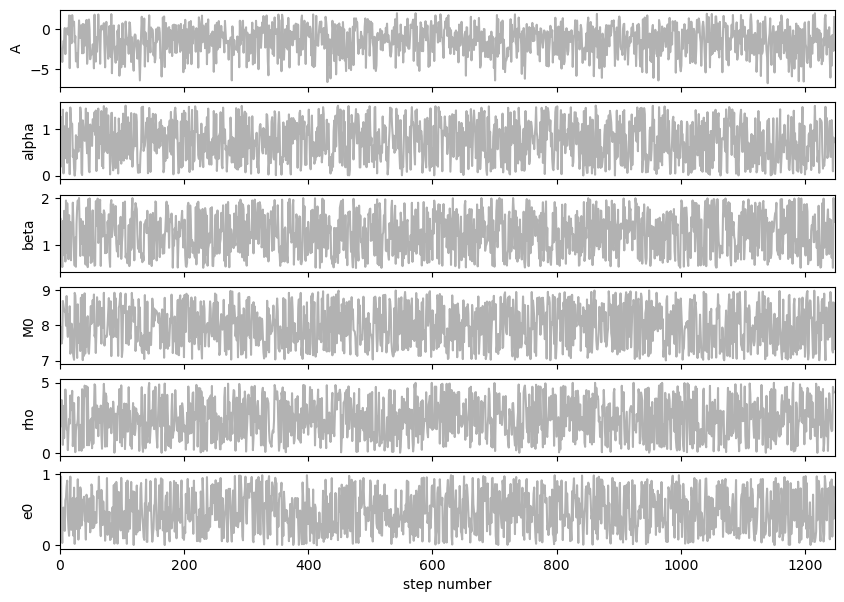

In [11]:
fig, axes = plt.subplots(6, figsize=(10, 7), sharex=True)
labels = ["A","alpha","beta","M0","rho","e0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    #ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

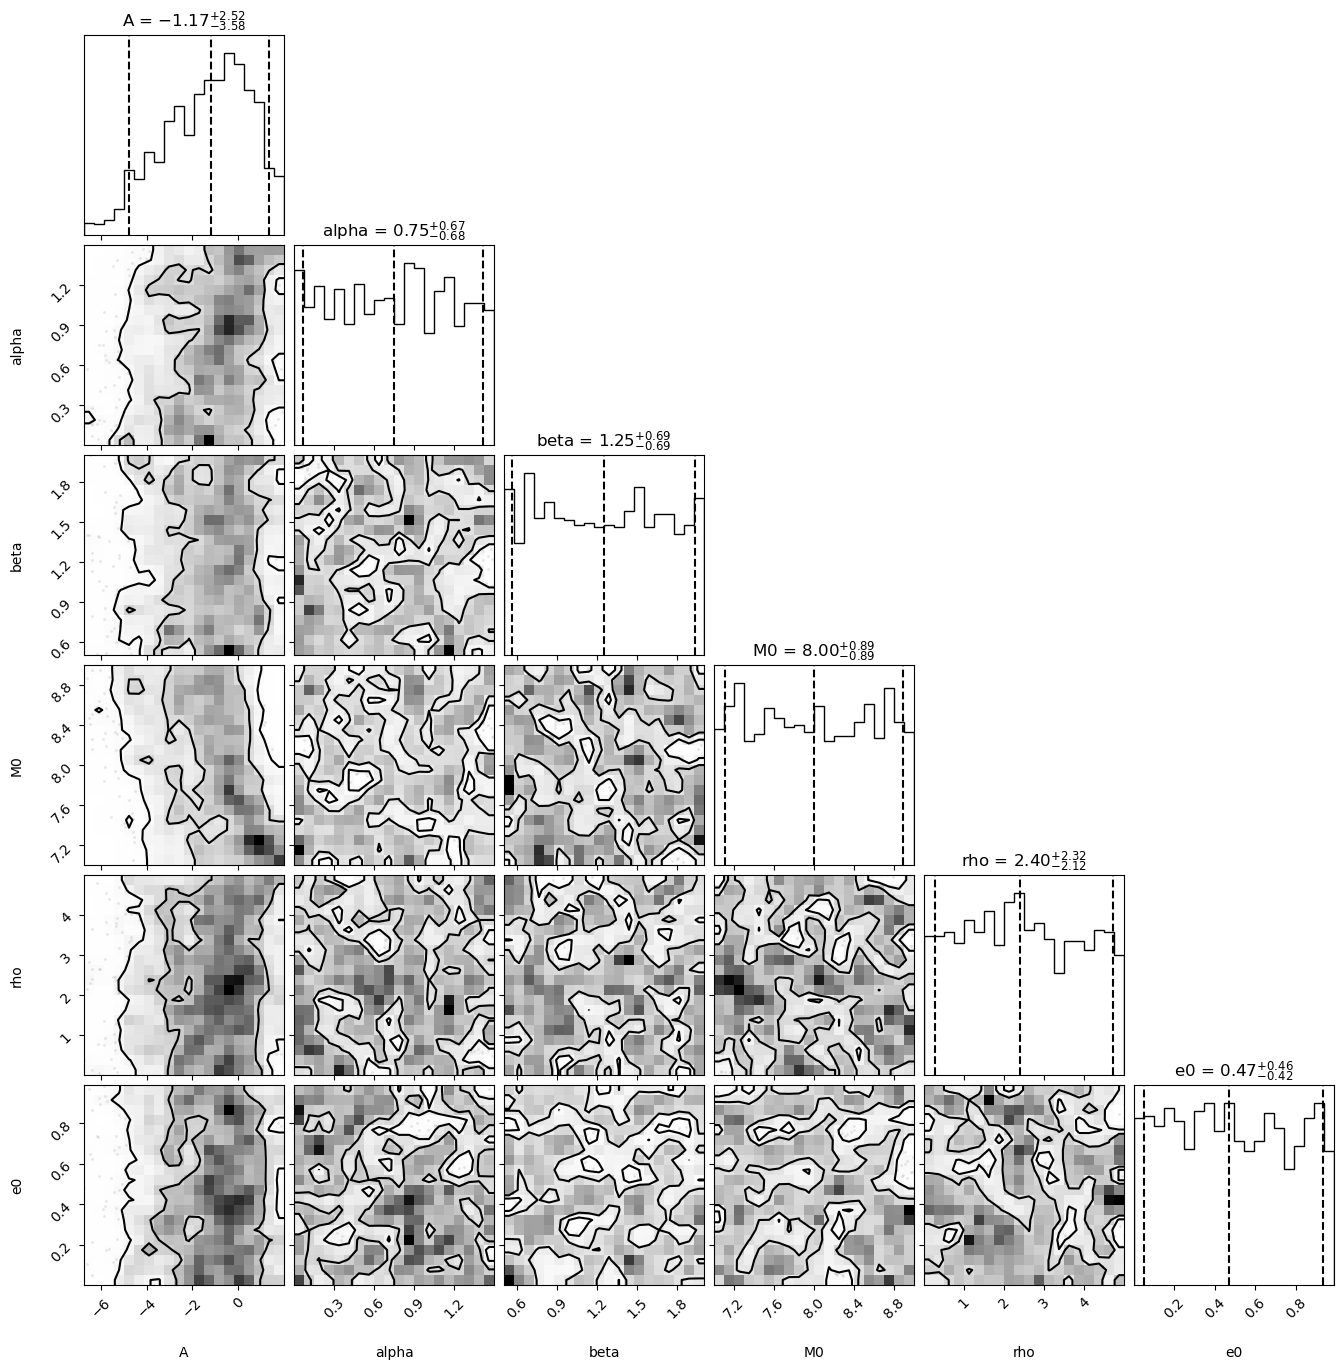

In [12]:
labels = ["A","alpha","beta","M0","rho","e0"]
fig = corner.corner(flat_samples, smooth=0.7, labels=labels, quantiles=[0.05,0.5,0.95], levels=[0.68,0.95], show_titles=True);